### Questions - what are the additive terms? 


In [79]:
import pandas as pd
from matplotlib import pyplot as plt
import re

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import numpy as np
import fbprophet
from fbprophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pylab import rcParams
import datetime

import logging

from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LinearRegression

from sklearn import metrics

logging.getLogger().setLevel(logging.ERROR)



In [80]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=4).mean()
    #pd.rolling_mean(timeseries, window=12)
    rolstd =  pd.Series(timeseries).rolling(window=4).std()
#Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    # dftest = adfuller(timeseries, autolag='AIC')
    dftest = adfuller(timeseries)
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


In [81]:
LME_futures = pd.read_excel('forecasting_raw_data/LME Futures Price.xlsx')
LME_futures = LME_futures.iloc[3:, 1:]
#LME_futures['Unnamed: 1'] = pd.datetime(LME_futures['Unnamed: 1'])
LME_futures.index = LME_futures['Unnamed: 1']



LME_futures = LME_futures.iloc[:, 1:]
LME_futures = LME_futures[LME_futures.index.year>=2000]
LME_futures.isnull().sum()
LME = LME_futures.iloc[:, 0]
LME = LME.astype(float)
LME = LME.resample('W').mean()


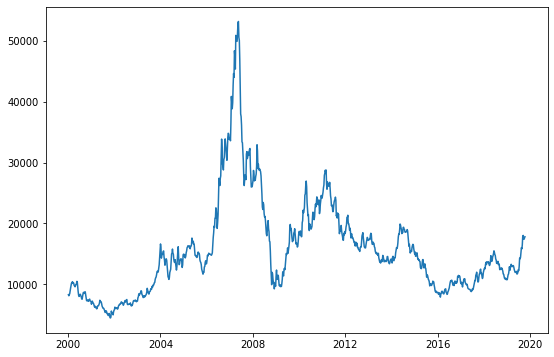

In [82]:
plt.plot(LME)

### Note About Preprocessing: 

#### For differenced data, to unscale, must concatenate the LAST VALUE OF THE ORIGINAL Y OF THE TRAINING SET, with the new PREDICTED SERIES OF SCALED_YHAT to use CUMSUM()

In [113]:
def preprocess(series):
    
    stationary = series.diff()
    return stationary
    
def unpreprocess(first, stationary_series):
    #first = training_y_series.last()
    '''With no gaps in time'''
    unscaled = np.r_[first ,stationary_series.cumsum()]
    unscaled = unscaled[1:]
    return unscaled
    

In [39]:
first = LME.iloc[0]
unscaled = np.r_[first ,LME_stationary[1:]].cumsum()
unscaled

array([ -74.5, -239.5, -245.5, ..., 9240.5, 9371.5, 9275.5])

#### Take Out Trend

Pandas time series resampling options
https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

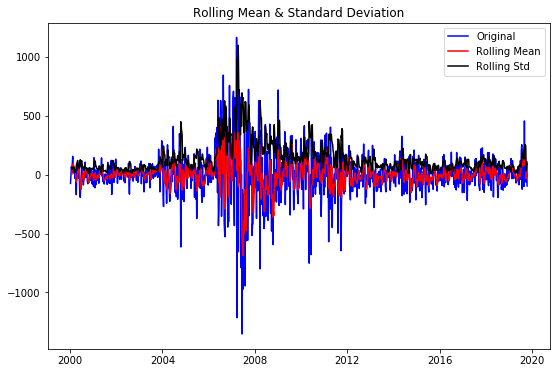

Results of Dickey-Fuller Test:
Test Statistic                -9.451713e+00
p-value                        4.597516e-16
#Lags Used                     1.100000e+01
Number of Observations Used    1.020000e+03
Critical Value (1%)           -3.436777e+00
Critical Value (5%)           -2.864378e+00
Critical Value (10%)          -2.568281e+00
dtype: float64
Rolling Mean Transformation
<class 'pandas.core.series.Series'>


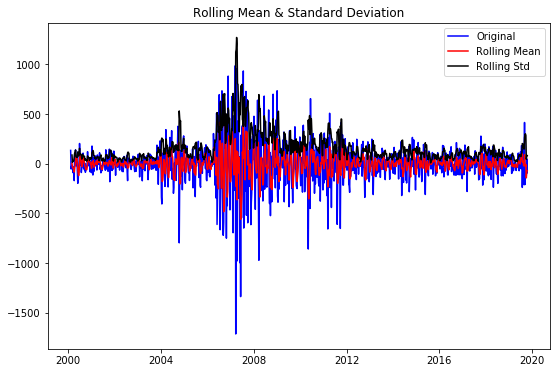

Results of Dickey-Fuller Test:
Test Statistic                -1.196739e+01
p-value                        3.971048e-22
#Lags Used                     2.200000e+01
Number of Observations Used    1.004000e+03
Critical Value (1%)           -3.436880e+00
Critical Value (5%)           -2.864423e+00
Critical Value (10%)          -2.568305e+00
dtype: float64


In [41]:
LME_stationary = preprocess(LME)

#LME_log = np.log(LME)
LME_log = LME
rcParams['figure.figsize'] = 9, 6

#plt.plot(LME_log)
#plt.show()
test_stationarity(LME_log)

print('Rolling Mean Transformation')
window_setting=5
moving_avg = LME_log.rolling(window=window_setting).mean()
#plt.plot(LME_log)
#plt.plot(moving_avg, color='red')
#plt.axvline('2018-5-1', color='red', linestyle='--')
#plt.show()

moving_diff = LME_log-moving_avg.shift()
moving_diff = moving_diff.dropna()
#moving_diff = moving_diff.to_frame()
print(type(moving_diff))
test_stationarity(moving_diff)

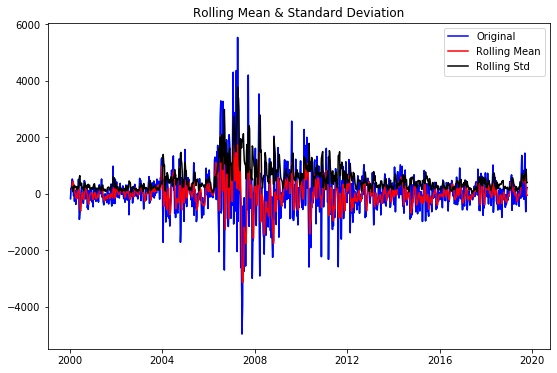

Results of Dickey-Fuller Test:
Test Statistic                -9.137728e+00
p-value                        2.904991e-15
#Lags Used                     9.000000e+00
Number of Observations Used    1.021000e+03
Critical Value (1%)           -3.436771e+00
Critical Value (5%)           -2.864375e+00
Critical Value (10%)          -2.568279e+00
dtype: float64


In [92]:
plt.plot(LME_stationary)

test_stationarity(LME_stationary.dropna())

In [93]:
list_one = list(LME_stationary.index)
list_two = list(LME_stationary)
df = pd.DataFrame(list(zip(list_one, list_two)), columns = ['ds', 'y'])
df.head()


df['lag1'] = df.y.shift(periods=1)
df['lag2'] = df.y.shift(periods=2)
df['lag3'] = df.y.shift(periods=3)
df['lag4'] = df.y.shift(periods=4)
df['lag5'] = df.y.shift(periods=5)


df.index = df['ds']
df = df.iloc[:, 1:]

df = df.dropna()

df.head(10)

,y,lag1,lag2,lag3,lag4,lag5
ds,,,,,,
2000-02-20,436.50,517.90,419.0,160.6,187.12,-173.42
2000-02-27,359.60,436.50,517.9,419.0,160.60,187.12
2000-03-05,-68.20,359.60,436.5,517.9,419.00,160.60
2000-03-12,296.20,-68.20,359.6,436.5,517.90,419.00
2000-03-19,-268.40,296.20,-68.2,359.6,436.50,517.90
2000-03-26,129.20,-268.40,296.2,-68.2,359.60,436.50
2000-04-02,-110.60,129.20,-268.4,296.2,-68.20,359.60
2000-04-09,-375.80,-110.60,129.2,-268.4,296.20,-68.20
2000-04-16,-38.25,-375.80,-110.6,129.2,-268.40,296.20


## Linear Regression

IMPORTANT NOTE TO SELF: 
For smoothing using moving average, must RESCALE output predictions using inputs!! 

SECOND NOTE 2 SELF: 
for training/fitting/testing set... 

MODEL FOR DEPLOYMENT: 
Train a model that uses values from a year ago or OLDER to predict values and rescale according to moving averages... 



In [94]:
X = df[['lag1', 'lag2', 'lag3', 'lag4', 'lag5']]
y= df['y']



In [95]:
X_train = X.loc[:'2018-10-14', :]
X_test = X.loc['2018-10-14':  ,:]

y_train = y[:'2018-10-14']
y_test = y['2018-10-14':]

In [96]:
regressor = LinearRegression()

regressor.fit(X_train, y_train)
print(regressor.coef_)

y_pred = regressor.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index
# y_pred = y_pred.reindex(X_test.index)


[ 0.28067602 -0.06851703  0.08808749 -0.03471988  0.02218616]


In [111]:
y_pred

ds
2018-10-14    -75.218169
2018-10-21     70.541127
2018-10-28    -97.613058
2018-11-04    -24.985136
2018-11-11   -147.274703
2018-11-18     17.014329
2018-11-25   -144.057161
2018-12-02    -43.584055
2018-12-09    -49.186683
2018-12-16     35.193113
2018-12-23    -76.113846
2018-12-30     38.463904
2019-01-06    -51.297159
2019-01-13     29.138953
2019-01-20    107.220601
2019-01-27     86.076810
2019-02-03     44.783001
2019-02-10    159.249013
2019-02-17    160.672306
2019-02-24   -157.853500
2019-03-03    196.590147
2019-03-10    -11.924931
2019-03-17    142.441773
2019-03-24   -124.787478
2019-03-31     72.777344
2019-04-07    -60.397430
2019-04-14     80.948589
2019-04-21    -38.027488
2019-04-28    -55.517346
2019-05-05    -98.220245
2019-05-12    -50.019656
2019-05-19    -71.419222
2019-05-26     27.126847
2019-06-02    -10.765401
2019-06-09     26.223548
2019-06-16   -129.281462
2019-06-23     55.750544
2019-06-30     22.288570
2019-07-07    130.877198
2019-07-14    -62.6828

In [78]:
test = unpreprocess(LME.loc[y_train.index[-1]], y_pred)

test

Unnamed: 1
2000-01-09    -74.50
2000-01-16     -7.66
2000-01-23     68.86
2000-01-30     30.40
2000-02-06     91.00
2000-02-13    155.00
2000-02-20     14.00
2000-02-27     48.20
2000-03-05     28.80
2000-03-12     43.20
2000-03-19    -32.20
2000-03-26    -18.00
2000-04-02    -22.00
2000-04-09   -170.60
2000-04-16     53.25
2000-04-23     -6.65
2000-04-30    106.00
2000-05-07    -29.60
2000-05-14     38.40
2000-05-21     81.20
2000-05-28    -41.00
2000-06-04   -167.00
2000-06-11   -193.20
2000-06-18    -89.00
2000-06-25    -50.80
2000-07-02     95.00
2000-07-09     16.00
2000-07-16    -56.00
2000-07-23      3.40
2000-07-30    -87.40
               ...  
2019-03-24     11.75
2019-03-31     -1.30
2019-04-07     18.10
2019-04-14     -9.15
2019-04-21    -70.65
2019-04-28    -46.90
2019-05-05    -43.40
2019-05-12    -50.30
2019-05-19     23.40
2019-05-26     69.00
2019-06-02    -75.10
2019-06-09    -85.90
2019-06-16     50.00
2019-06-23     45.30
2019-06-30    119.70
2019-07-07    -39.80
20

In [109]:
# y_train.iloc[-1]

LME.loc[y_train.index[-1]]
y_train.index[-1]

Timestamp('2018-10-14 00:00:00')

In [63]:
results = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
results

,y_test,y_pred
1970-01-01 00:00:00.000000000,NaN,NaN
1970-01-01 00:00:00.000000001,NaN,NaN
1970-01-01 00:00:00.000000002,NaN,NaN
1970-01-01 00:00:00.000000003,NaN,NaN
1970-01-01 00:00:00.000000004,NaN,NaN
1970-01-01 00:00:00.000000005,NaN,NaN
1970-01-01 00:00:00.000000006,NaN,NaN
1970-01-01 00:00:00.000000007,NaN,NaN
1970-01-01 00:00:00.000000008,NaN,NaN
1970-01-01 00:00:00.000000009,NaN,NaN


In [55]:
start_price = LME_log.first('D')
start_price

Unnamed: 1
2000-01-09   -74.5
Freq: W-SUN, Name: Cash Price ($/MT), dtype: float64

In [ ]:
# FOR DIFF MODELING BACK TO SCALE


# !!! Backwards diff
start_price = LME_log.first('D')

#scaled_yhat =forecast['yhat'].rolling(2).sum().shift(-1)
nondiff = start_price.append(y_pred).cumsum().dropna()
#scaled_yhat = scaled_yhat['2017-10-22':]


scaled_y = start_price.append(LME_diff).cumsum().dropna()
scaled_y = scaled_y['2017-10-22':]

#shifted_by_avg = moving_avg['2018-05-15':]

#scaled_yhat = forecast['yhat'] + moving_avg['2018-05-15':]



actual_y = LME_log['2017-10-22':]



In [91]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


Mean Absolute Error: 73.88762252233565
Mean Squared Error: 10697.306413915481
Root Mean Squared Error: 103.4277835686112


## Modeling the Moving Average!! 

- Will start at the end of the training data and is used ONLY TO FILL IN THE SPACE between the evaluated values and the training data 


## Weekly

In [209]:
LME_log_train = LME_log[:-prediction_size-gap_size]

original_tail = LME_log_train.rolling(window=window_setting).mean().tail(window_setting)



'''Rescaling predicted values back to scale using rolling mean'''

results = []

ys_for_avgs = original_tail.to_dict()

'''Identify date in KEY, predicted value in ITEM'''
for key, item in forecast['yhat'].items():
    
    '''Manually calculate sum'''
    rolling_avg = 0
    for i in range(window_setting):
        # Weekly
        time_frame_ref = key +datetime.timedelta(weeks=-i-1)
        
        # Daily
        #time_frame_ref = key - pd.tseries.offsets.BusinessDay(n= i+1)
        
        
        '''look up time_frame_ref in dictionary'''
        rolling_avg = rolling_avg + ys_for_avgs[time_frame_ref]
    #print('resulting avg: ', rolling_avg/window_setting)
    
    #singular_avg = 
    scaled = item + rolling_avg/window_setting
    results.append(scaled)
    ys_for_avgs[key] = scaled

forecast['scaled_yhat'] = results

## Back to Scale before Performance Analysis

In [214]:
test_forecast = forecast.iloc[-prediction_size:,:]


test_start_date = test_forecast.index[0]

yhat = test_forecast['yhat']

y = moving_diff[test_start_date:]
#shifted_by_avg = moving_avg[test_start_date:]

scaled_yhat = test_forecast['scaled_yhat'] 

#scaled_y =  moving_diff[test_start_date:] + moving_avg[test_start_date:]
#scaled_y = 

actual_y = LME_log[test_start_date:]


In [120]:
'''
y = moving_diff['2018-05-15':]
shifted_by_avg = moving_avg['2018-05-15':]


scaled_yhat = forecast['yhat'] + moving_avg['2018-05-15':]
scaled_yhat

scaled_y =  moving_diff['2018-05-15':] + moving_avg['2018-05-15':]
scaled_y

actual_y = LME_log['2018-05-15':]
'''

"\ny = moving_diff['2018-05-15':]\nshifted_by_avg = moving_avg['2018-05-15':]\n\n\nscaled_yhat = forecast['yhat'] + moving_avg['2018-05-15':]\nscaled_yhat\n\nscaled_y =  moving_diff['2018-05-15':] + moving_avg['2018-05-15':]\nscaled_y\n\nactual_y = LME_log['2018-05-15':]\n"

In [219]:

#####################

frame = { 'scaled_yhat': scaled_yhat, 'actual_y': actual_y } 
  
results = pd.DataFrame(frame) 

results['error'] = results['actual_y'] - results['scaled_yhat']
results.head()

results['unlogged_scaled_yhat'] = np.exp(results['scaled_yhat'])
results['original_y'] = LME[test_start_date:]

results['error'] = results['original_y'] - results['unlogged_scaled_yhat']

# Mean error results
print(np.abs(results['error']).mean())
print(mean_absolute_error(results['original_y'], results['unlogged_scaled_yhat'] ))





8025.516691969699


KeyError: 'unlogged_scaled_yhat'

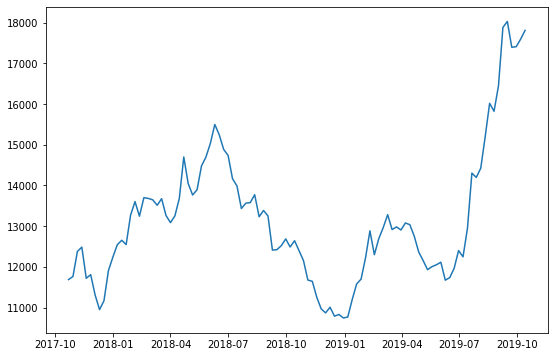

In [221]:
plt.plot(results['original_y'])
plt.plot(results['unlogged_scaled_yhat'], color='red')
plt.title("Prediction Results - Unscaled", fontsize=20)
plt.ylabel('in $', fontsize=15)
#plt.axvline('2018-5-1', color='red', linestyle='--')
plt.savefig('unscaled_by_week.jpg', bbox_inches='tight')
plt.legend(['Actual Prices', 'Predicted Prices'])
plt.show()

print('MAE: ', np.abs(results['error']).mean() )

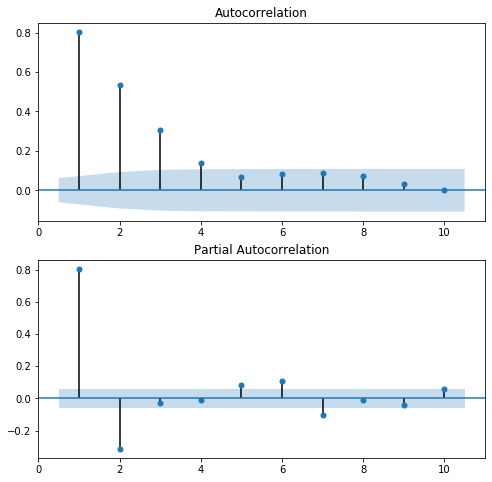

In [133]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))

# make acf plot
plot_acf(moving_diff, lags=10, zero=False, ax=ax1)
#plt.savefig('acf_weekly.jpg', bbox_inches='tight')
plot_pacf(moving_diff, lags=10, zero=False, ax=ax2)
#plt.savefig('pacf_weekly.jpg', bbox_inches='tight')


Results, ACF tails off and PACF cutts off after lag p=2

#### Thus, AR(2) is the model

#### Forecasting with SARIMAX

https://campus.datacamp.com/courses/forecasting-using-arima-models-in-python/chapter-2-fitting-the-future?ex=5

### ARMA (2, 0)


https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/

In [169]:
threshold_index = train_df.shape[0]
threshold_date = train_df.iloc[threshold_index-1, 0]

# Use trend = c if the time series is not centered around 0
model = SARIMAX(moving_diff[:threshold_date], order=(2, 0, 0))


# Making one-step-ahead predictions 
results= model.fit()
#forecast = results.get_prediction(start=52, dynamic=True)


# Create forecast object
forecast_object = results.get_forecast(steps=104)

# Extract prediction mean
mean = forecast_object.predicted_mean

# Extract the confidence intervals
conf_int = forecast_object.conf_int()

# Extract the forecast dates
dates = mean.index



In [182]:
cmp_df = pd.DataFrame({'y_hat':mean})


,y_hat
2016-10-23,2.438216e-02
2016-10-30,1.831901e-02
2016-11-06,1.161385e-02
2016-11-13,6.459259e-03
2016-11-20,3.142259e-03
2016-11-27,1.272986e-03
2016-12-04,3.497431e-04
2016-12-11,-3.329782e-05
2016-12-18,-1.455660e-04
2016-12-25,-1.429594e-04


In [184]:
LME_log_train = LME_log[:threshold_date]

original_tail = LME_log_train.rolling(window=window_setting).mean().tail(window_setting)

'''Rescaling predicted values back to scale using rolling mean'''

results = []

ys_for_avgs = original_tail.to_dict()

'''Identify date in KEY, predicted value in ITEM'''
for key, item in mean.items():
    
    '''Manually calculate sum'''
    rolling_avg = 0
    for i in range(window_setting):
        # Weekly
        time_frame_ref = key +datetime.timedelta(weeks=-i-1)
        
        # Daily
        #time_frame_ref = key - pd.tseries.offsets.BusinessDay(n= i+1)
        
        
        '''look up time_frame_ref in dictionary'''
        rolling_avg = rolling_avg + ys_for_avgs[time_frame_ref]
    #print('resulting avg: ', rolling_avg/window_setting)
    
    #singular_avg = 
    scaled = item + rolling_avg/window_setting
    results.append(scaled)
    ys_for_avgs[key] = scaled

cmp_df['scaled_yhat'] = results

################################




In [191]:
test_forecast = mean
test_start_date = test_forecast.index[0]

yhat = test_forecast

y = moving_diff[test_start_date:]
#shifted_by_avg = moving_avg[test_start_date:]

scaled_yhat = cmp_df['scaled_yhat'] 
actual_y = LME_log[test_start_date:]

#####################

frame = { 'scaled_yhat': scaled_yhat, 'actual_y': actual_y } 
  
results = pd.DataFrame(frame) 

results['error'] = results['actual_y'] - results['scaled_yhat']
results.head()

results['unlogged_scaled_yhat'] = np.exp(results['scaled_yhat'])
results['original_y'] = LME[test_start_date:]
results['error'] = results['original_y'] - results['unlogged_scaled_yhat']
results = results.dropna()
# Mean error results
print(np.abs(results['error']).mean())
print(mean_absolute_error(results['original_y'].dropna(), results['unlogged_scaled_yhat'].dropna() ))


1766.9528005947411
1766.9528005947416


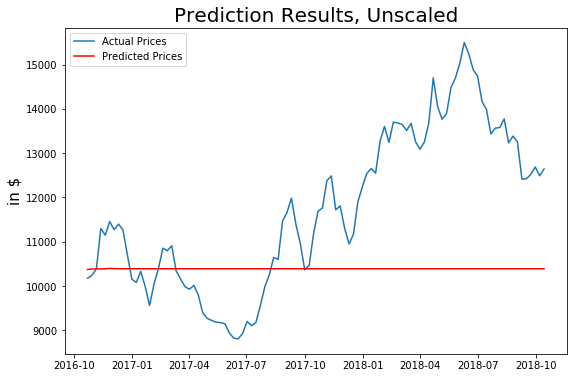

MAE:  1766.9528005947411


In [198]:
plt.plot(results['original_y'])
plt.plot(results['unlogged_scaled_yhat'], color='red')
plt.title("Prediction Results, Unscaled", fontsize=20)
plt.ylabel('in $', fontsize=15)
#plt.axvline('2018-5-1', color='red', linestyle='--')
plt.savefig('unscaled_by_week_ARIMA.jpg', bbox_inches='tight')
plt.legend(['Actual Prices', 'Predicted Prices'])
plt.show()

print('MAE: ', np.abs(results['error']).mean() )

In [42]:
'''Joins predicted values with actual values'''
def make_comparison_dataframe(historical, forecast):
    
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

# Creating comparison dataframe
cmp_df = make_comparison_dataframe(df, forecast)



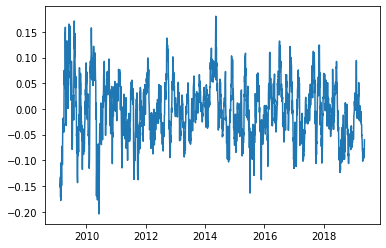

In [49]:
cmp_df['error'] =  cmp_df['y'] - cmp_df['yhat']
cmp_df.head()
plt.plot(cmp_df['error'])

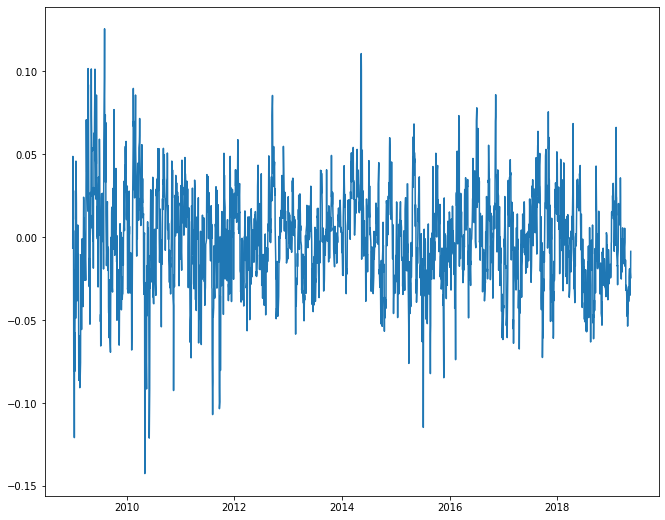

In [151]:
plt.plot(cmp_df['error'])

In [51]:
cmp_df = cmp_df.dropna()

def calculate_forecast_errors(df, prediction_size):
    df = df.copy()
    df['error'] = df['y'] - df['yhat']
    df['percentage'] = 100*df['error']/df['y']
    
    
    predicted_part = df[-prediction_size:]
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    print(predicted_part.head())
    return {'MAPE': error_mean('percentage'), 'MAE': error_mean('error')}

for err_name, err_value in calculate_forecast_errors(cmp_df.dropna(), prediction_size).items():
    print(err_name, err_value)

                yhat  yhat_lower  yhat_upper         y     error  percentage
ds                                                                          
2017-12-20  0.030911   -0.038317    0.101200  0.042610  0.011699   27.455771
2017-12-21  0.030106   -0.045255    0.099914  0.046177  0.016070   34.801897
2017-12-22  0.030545   -0.037697    0.100828  0.051237  0.020692   40.384256
2017-12-25  0.029742   -0.038494    0.100844  0.052215  0.022473   43.039938
2017-12-26  0.027537   -0.041608    0.098748  0.051225  0.023688   46.242715
MAPE 570.8182329084178
MAE 0.04271461087194927


In [45]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(((y_pred - y_true) **2).mean())
    #return np.mean(np.abs((y_true - y_pred) / y_true))*100


In [47]:
print('mape', mean_absolute_percentage_error(cmp_df['y'], cmp_df['yhat']))

print('rmse', root_mean_squared_error(cmp_df['y'], cmp_df['yhat']))

mape 219.83967767924054
rmse 0.05529372373011725


In [97]:
pd.DataFrame({'mean':tester.rolling(window=3).mean(), 'original': tester})

,mean,original
0,NaN,1.0
1,NaN,2.0
2,2.000000,3.0
3,3.000000,4.0
4,6.000000,11.0
5,7.000000,6.0
6,8.000000,7.0
7,7.000000,8.0
8,8.000000,9.0
9,5.833333,0.5
